[*********************100%***********************]  4 of 4 completed
/var/folders/rn/q0k246v15yz0vm0xsf9wg9lm0000gn/T/ipykernel_33947/1863627707.py:69: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("A").sum().pipe(np.exp).sub(1))
/var/folders/rn/q0k246v15yz0vm0xsf9wg9lm0000gn/T/ipykernel_33947/1863627707.py:53: RuntimeWarning: invalid value encountered in log1p
  e_log = np.sum(np.log1p(m) - 0.5*v/(1+m)**2)


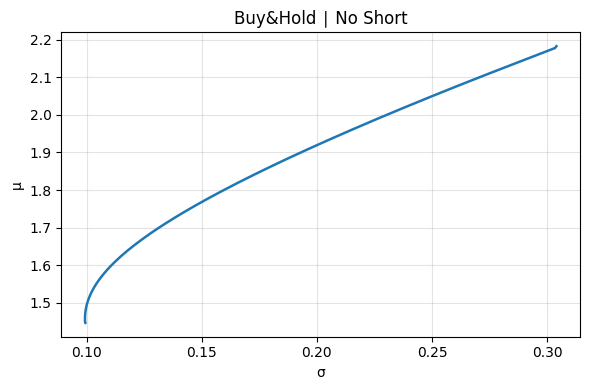

saved q7_BuyandHold_NoShort.png


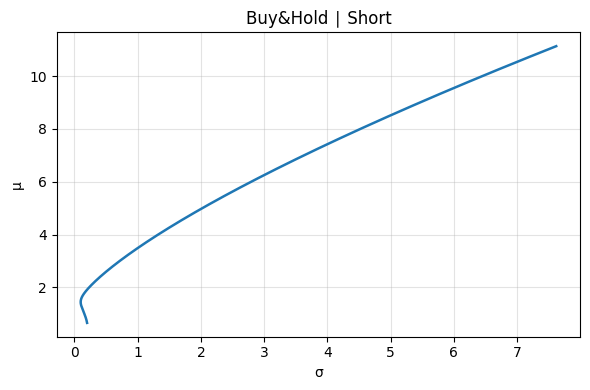

saved q7_BuyandHold_Short.png


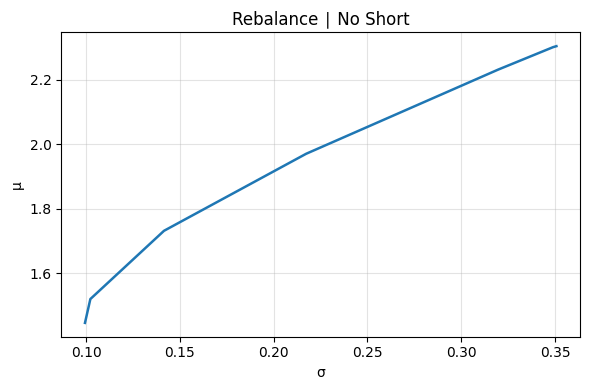

saved q7_Rebalance_NoShort.png


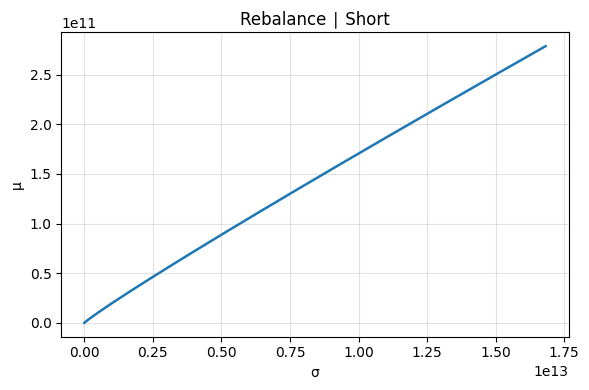

saved q7_Rebalance_Short.png


In [ ]:
import time, pickle, numpy as np, pandas as pd, yfinance as yf
import matplotlib.pyplot as plt
from   scipy.stats import norm

def psd_shift(A, eps=1e-10):
    A = 0.5*(A + A.T)
    w, _ = np.linalg.eigh(A)
    if w.min() < eps:
        A += (eps - w.min()) * np.eye(A.shape[0])
    return A

def markowitz(mu, Sig, mu_t, longonly):
    invS, o = np.linalg.inv(Sig), np.ones_like(mu)
    A, B, C = o@invS@o, o@invS@mu, mu@invS@mu
    l1 = (C - mu_t*B) / (A*C - B**2)
    l2 = (mu_t*A - B) / (A*C - B**2)
    w  = invS @ (l1*o + l2*mu)
    if longonly and (w < 0).any():
        w = np.clip(w, 0, None); w /= w.sum()
    return w

def kmatrix(mu, Sig, mu_t, T, longonly):
    a  = (1+mu)**T
    P  = (1+mu[:,None] + mu[None,:] + Sig + mu[:,None]*mu[None,:])**T
    K  = psd_shift(P - np.outer(a,a))
    invK, o = np.linalg.inv(K), np.ones_like(mu)
    A, B, C = o@invK@o, o@invK@a, a@invK@a
    l1 = (C - mu_t*B) / (A*C - B**2)
    l2 = (mu_t*A - B) / (A*C - B**2)
    w  = invK @ (l1*o + l2*a)
    if longonly and (w < 0).any():
        w = np.clip(w, 0, None); w /= w.sum()
    return w

def wealth_moments(w_path, mu_true, Sig_true):
    m = np.array([w@mu_true            for w in w_path])
    v = np.array([w@Sig_true@w         for w in w_path])
    e_log = np.sum(np.log1p(m) - 0.5*v/(1+m)**2)
    v_log = np.sum(np.log1p(v/(1+m)**2))
    mean  = np.exp(e_log + 0.5*v_log)
    std   = np.sqrt((np.exp(v_log) - 1) * np.exp(2*e_log + v_log))
    return mean, std

px = yf.download(["^SP500TR","VBMFX","^SPGSCI","^IRX"],
                 start="1990-12-31", end="2025-01-01",
                 interval="1mo")["Close"]

rf = (1 + px["^IRX"].ffill()/100/12).cumprod();  rf.name = "RF"
lvl = pd.concat([px[["^SP500TR","VBMFX","^SPGSCI"]], rf], axis=1)
lvl.columns = ["EQ","BD","CM","RF"];  lvl = lvl.ffill()

ret_y = (np.log(lvl).diff().loc["1991-01":]
         .resample("A").sum().pipe(np.exp).sub(1))
train_ret   = ret_y.loc["1991":"2012"].values
oos_ret     = ret_y.loc["2013":"2025"].values       # 13×4

mu_true  = train_ret.mean(0)
Sig_true = np.cov(train_ret.T)

mu0 = np.zeros(4)
rho = np.array([[ 1,-.3, .3,0],[-.3, 1,-.3,0],[ .3,-.3, 1,0],[0,0,0,1]])
z   = norm.ppf(0.10)
tau = (1+mu0)/abs(z);  tau[3] = 1e-3
Lam0      = np.diag(tau) @ rho @ np.diag(tau)
Lam0_inv  = np.linalg.inv(Lam0)
n_hist    = train_ret.shape[0]
sum_x     = train_ret.sum(0)
sum_xx    = train_ret.T @ train_ret

def post_mean(n, sx, sxx):
    xbar = sx / n
    S_emp= (sxx - n*np.outer(xbar,xbar)) / (n-1)
    invL = Lam0_inv + n*np.linalg.inv(S_emp+1e-6*np.eye(4))
    Lam_n= np.linalg.inv(invL)
    mu_n = Lam_n @ (Lam0_inv@mu0 + n*np.linalg.inv(S_emp+1e-6*np.eye(4))@xbar)
    return mu_n, S_emp

def frontier(kind, short_ok, mu_grid):
    mean, std = [], []
    for mu_t in mu_grid:
        n, sx, sxx = n_hist, sum_x.copy(), sum_xx.copy()
        w_fixed, w_path = None, []
        for y in range(oos_ret.shape[0]):         # 13 years
            mu_n, Sig_n = post_mean(n, sx, sxx)
            if kind == "hold":
                w = kmatrix(mu_n, Sig_n, mu_t, 20, longonly=not short_ok)
                if w_fixed is None: w_fixed = w.copy()
                w = w_fixed
            else:
                w = markowitz(mu_n, Sig_n, mu_t, longonly=not short_ok)
            w_path.append(w)
            r_real = oos_ret[y]
            n    += 1;  sx += r_real;  sxx += np.outer(r_real, r_real)
        m, s = wealth_moments(w_path, mu_true, Sig_true)
        mean.append(m); std.append(s)
    return dict(mu=mu_grid, mean=np.array(mean), std=np.array(std))

t0 = time.time()
mu_grid = np.linspace(-2, 10, 1000)

buy = {lbl: frontier("hold", shrt, mu_grid)
       for shrt, lbl in [(False, "NoShort"), (True, "Short")]}
reb = {lbl: frontier("reb",  shrt, mu_grid)
       for shrt, lbl in [(False, "NoShort"), (True, "Short")]}

import os, re
os.makedirs("frontier_plots", exist_ok=True)   # 저장 폴더

def safe_name(txt):
    """파일 이름에 쓸 수 있도록 간단히 sanitzation"""
    txt = re.sub(r"[∣|]", "_", txt).replace("&", "and")
    return re.sub(r"[^-_.a-zA-Z0-9]", "", txt)

frontiers = [
    ("Buy&Hold ∣ No Short",  buy["NoShort"]),
    ("Buy&Hold ∣ Short",     buy["Short"]),
    ("Rebalance ∣ No Short", reb["NoShort"]),
    ("Rebalance ∣ Short",    reb["Short"]),
]

for title, d in frontiers:
    plt.figure(figsize=(6,4))
    plt.plot(d["std"], d["mean"], lw=1.8)
    plt.xlabel("σ")
    plt.ylabel("μ")
    plt.title(title)
    plt.grid(alpha=.35)
    plt.tight_layout()
    fname = f"q7_{safe_name(title)}.png"
    plt.savefig(fname, dpi=150)
    plt.show()          # 주피터/인터랙티브 환경이면 창에 바로 표시
    print(f"saved {fname}")
